In [32]:
#common imports
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
from class_and_functions_for_combinations import *


def save_fig(name, fig):
    fig.savefig(f'thesis_figures/{name}.eps', format='eps', dpi=10000, bbox_inches='tight')

#define standard matplotlib colors
C1 = (155/255, 0/255 ,20/255)
C2 = (1.1*4/255, 1.1*100/255, 1.1*218/255)#(4/255, 100/255, 218/255)

assert False, 'Do not do a run all, it is designed to be run cell by cell, and will fail if you do a run all'

AssertionError: Do not do a run all, it is designed to be run cell by cell, and will fail if you do a run all

## Performance metrics

MSE:  19.63039
MAE:  3.7011592


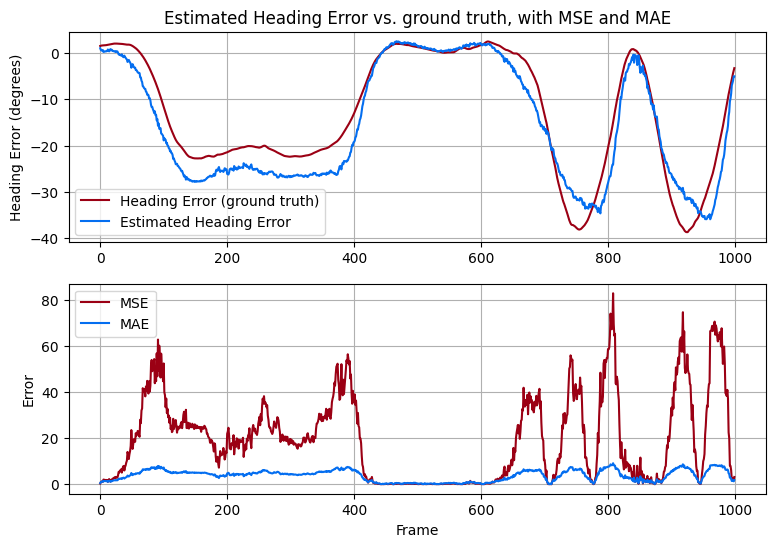

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
# PERFORMANCE METRCIS: MSE
ds_name = 'saved_tests/cw0.npz'
ds = np.load(ds_name)
imgs, locs = ds['imgs'], ds['locs']
path = np.load('sparcs/sparcs_path_precise.npy').T
onnx_model_path = 'Simulator/models/lane_keeper_ahead.onnx'
onnx_model = cv.dnn.readNetFromONNX(onnx_model_path)
dist_ahead = 0.8

hes, est_hes, MSEs, MAEs = [], [], [], []
for i in range(1000):
    img = imgs[i]
    x,y,yaw = locs[i]

    he, _, _ = get_heading_error(x, y, yaw, path, dist_ahead)
    est_he = get_est_heading_error(img, onnx_model)

    #convert to degrees
    he = np.rad2deg(he)
    est_he = np.rad2deg(est_he)

    mse = (he - est_he)**2
    mae = np.abs(he - est_he)

    hes.append(he)
    est_hes.append(est_he)
    MSEs.append(mse)
    MAEs.append(mae)

print('MSE: ', np.mean(MSEs))
print('MAE: ', np.mean(MAEs))

hes, est_hes, MSEs, MAEs = np.array(hes), np.array(est_hes), np.array(MSEs), np.array(MAEs)

#plot
fig, ax = plt.subplots(2,1, figsize=(9,6))
ax[0].plot(hes, label='Heading Error (ground truth)', color=C1)
ax[0].plot(est_hes, label='Estimated Heading Error', color=C2)
ax[0].set_ylabel('Heading Error (degrees)')
ax[0].legend()
ax[0].grid(True)
ax[0].set_axisbelow(True)
#title
ax[0].set_title('Estimated Heading Error vs. ground truth, with MSE and MAE')

ax[1].plot(MSEs, label='MSE', color=C1)
ax[1].plot(MAEs, label='MAE', color=C2)
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Error')
ax[1].legend()
ax[1].grid(True)
ax[1].set_axisbelow(True)
#y axis in log scale
# ax[1].set_yscale('log')

plt.show()

#save figure in vector format
save_fig('performance_metrics_example', fig)



## Evaluation dataset analysis

100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


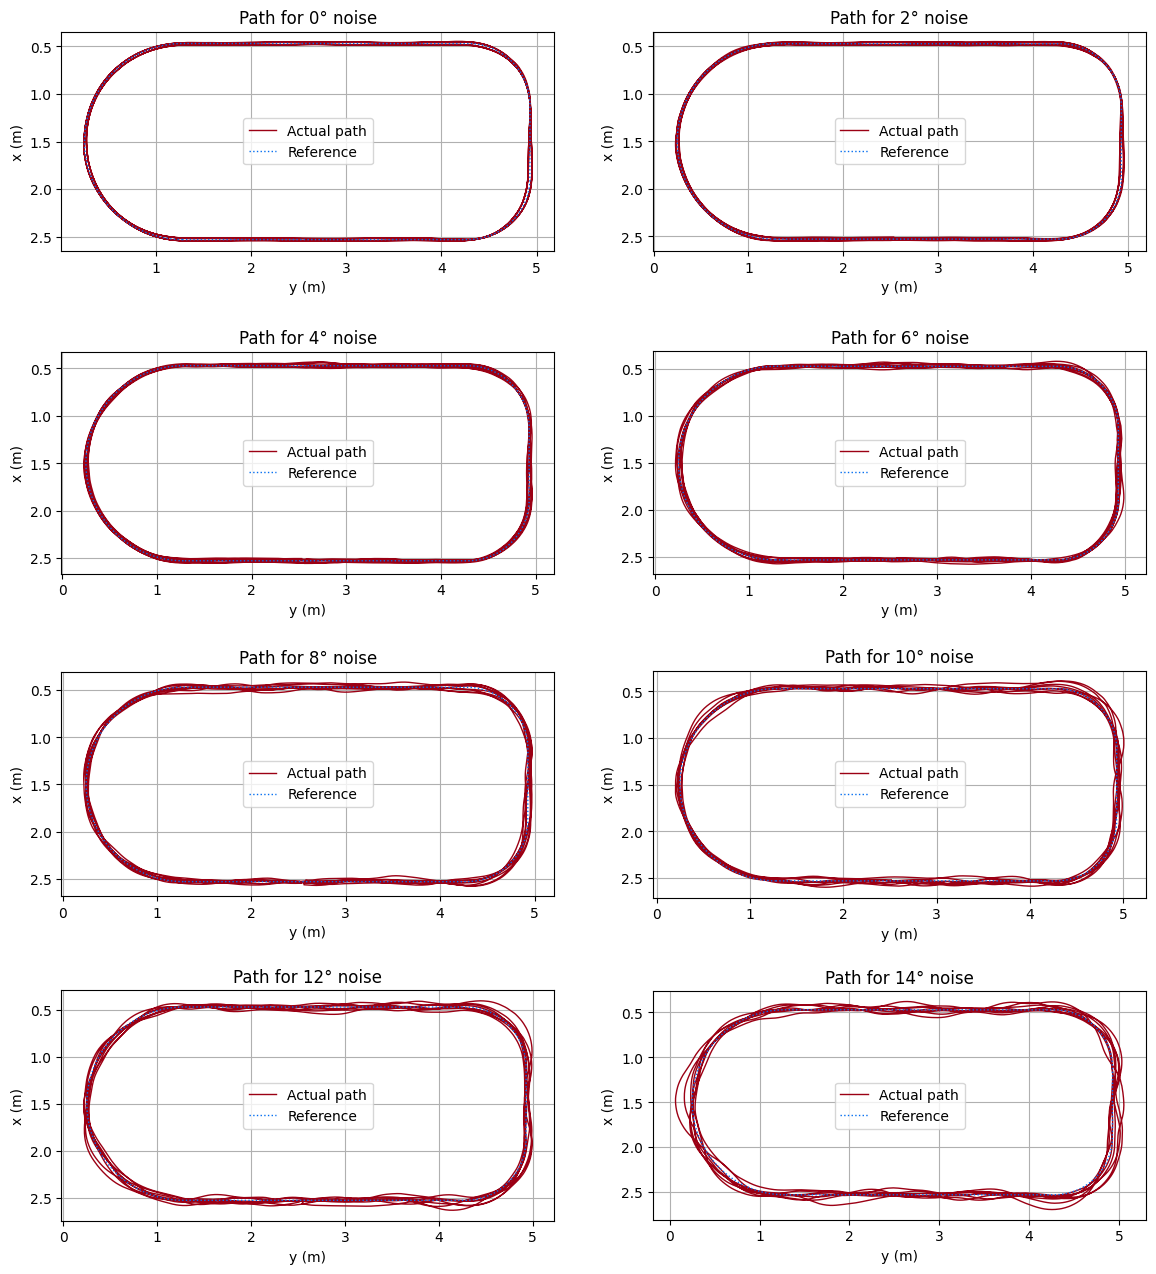

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [33]:
# DATASET ANALYSIS 1
names = ['cw0', 'cw2', 'cw4', 'cw6', 'cw8', 'cw10', 'cw12', 'cw14', 'acw0', 'acw2', 'acw4', 'acw6', 'acw8', 'acw10', 'acw12', 'acw14']
folder = 'tmp/real_dss/'
he_dists = [.2,.3,.4,.5,.6,.7,.8,.9]

dss = []
for i in tqdm(range(8)):
    name = names[i]
    #keep only the numbers
    val_name = name[2:]
    cw = my_load(folder + names[i] + '.npz')
    acw = my_load(folder + names[i+8] + '.npz')
    cw_imgs, cw_locs = cw['imgs'], cw['locs']
    acw_imgs, acw_locs = acw['imgs'], acw['locs']
    imgs = np.concatenate((cw_imgs, acw_imgs))
    locs = np.concatenate((cw_locs, acw_locs))

    hes = {}
    for he_dist in he_dists:
        cwhe_name = f'tmp/hes/{names[i]}_{he_dist*100:.0f}.npz'
        acwhe_name = f'tmp/hes/{names[i+8]}_{he_dist*100:.0f}.npz'
        cwhe = my_load(cwhe_name)
        acwhe = my_load(acwhe_name)
        cw_hes = cwhe['hes']
        acw_hes = acwhe['hes']
        hes[he_dist] = np.concatenate((cw_hes, acw_hes))

    dss.append({'name': val_name, 'imgs': imgs, 'locs': locs, 'hes': hes})

path = np.load('sparcs/sparcs_path_precise.npy').T


#create figure
fig, ax = plt.subplots(4,2, figsize=(14,16))

for i, ds in enumerate(dss):
    imgs, locs, hes, name = ds['imgs'], ds['locs'], ds['hes'], ds['name']
    #plot
    ax[i//2, i%2].plot(locs[:,1], locs[:,0], label='Actual path', color=C1, linestyle='-', linewidth=1)
    ax[i//2, i%2].grid(True)
    ax[i//2, i%2].set_axisbelow(True)
    ax[i//2, i%2].set_aspect('equal')
    ax[i//2, i%2].plot(path[:,1], path[:,0], label='Reference', color=C2, linestyle=':', linewidth=1)
    ax[i//2, i%2].set_title(f'Path for {name}° noise')
    ax[i//2, i%2].legend()
    #invert y axis
    ax[i//2, i%2].invert_yaxis()
    ax[i//2, i%2].set_xlabel('y (m)')
    ax[i//2, i%2].set_ylabel('x (m)')

#show fig
plt.show()

#save figure in vector format
save_fig('dataset_analysis1', fig)


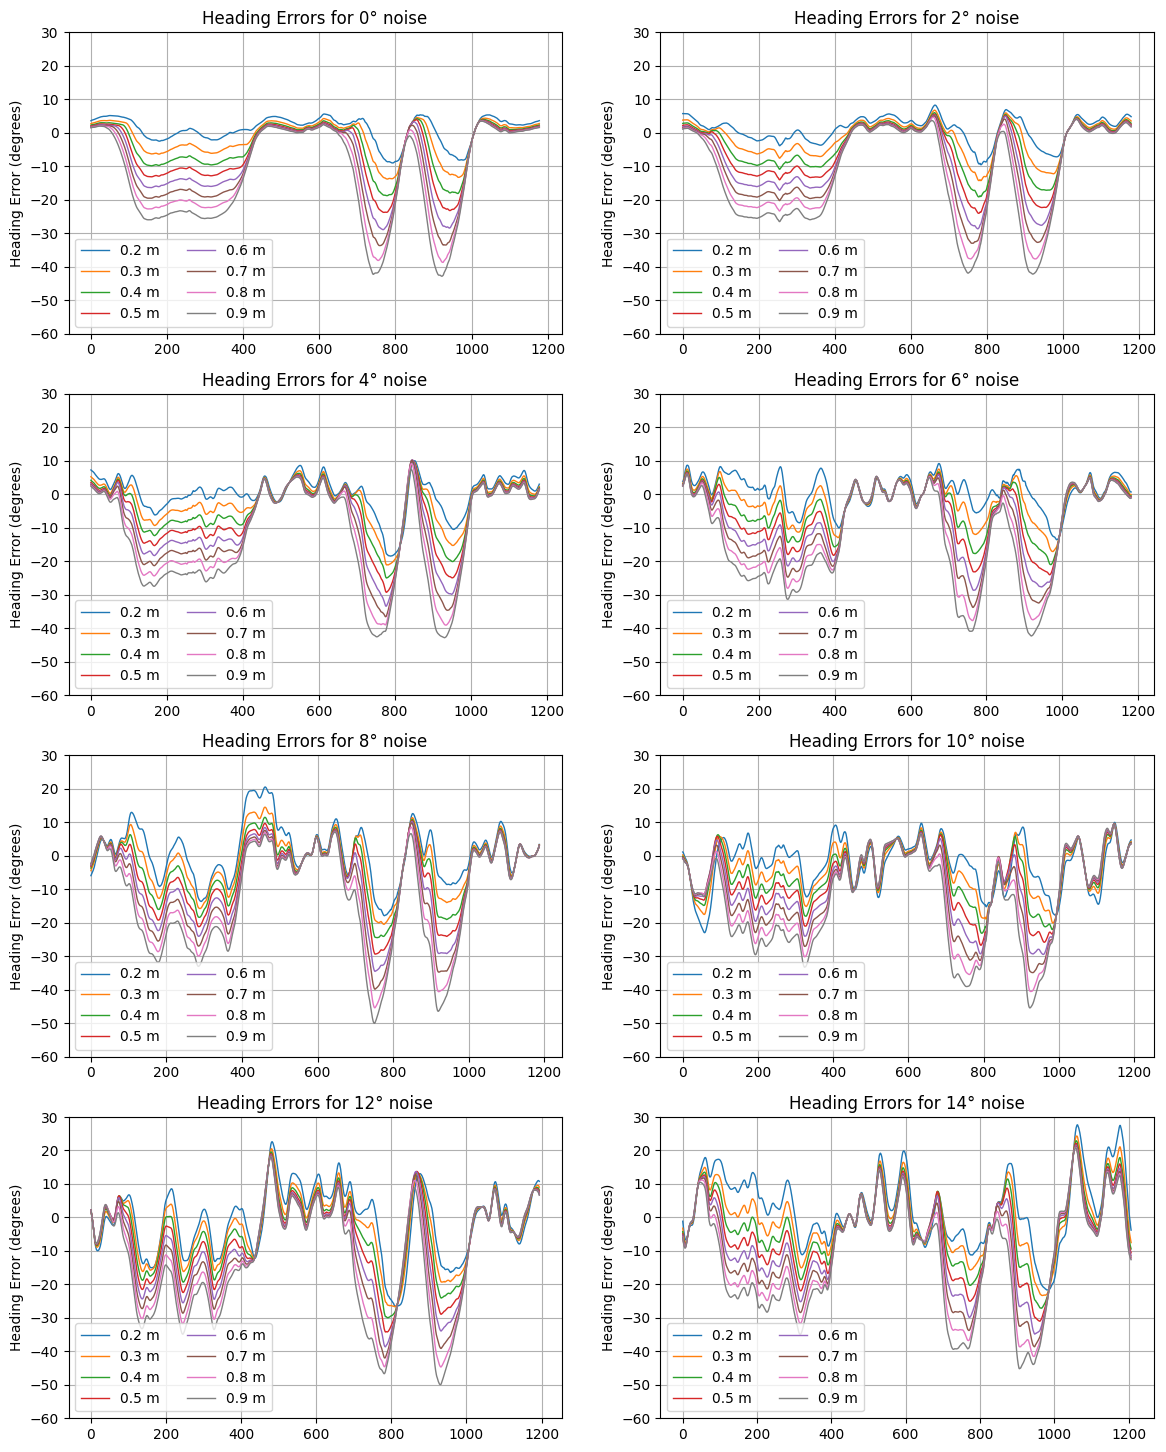

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [34]:
# DATASET ANALYSIS 2
#check dss exists
assert len(dss) > 0

#create figure
fig, ax = plt.subplots(4,2, figsize=(14,18))

for i, ds in enumerate(dss):
    hes, name = ds['hes'], ds['name']
    #select only the first 1/8 of the data
    hes = {k: v[:len(v)//8] for k, v in hes.items()}

    #plot
    for he_dist, he in hes.items():
        he = np.rad2deg(he)
        ax[i//2, i%2].plot(he, label=f'{he_dist} m', linewidth=1)

    ax[i//2, i%2].grid(True)
    ax[i//2, i%2].set_axisbelow(True)
    ax[i//2, i%2].set_title(f'Heading Errors for {name}° noise')
    #set legend with 2 columns
    ax[i//2, i%2].legend(ncol=2)
    # ax[i//2, i%2].legend()
    ax[i//2, i%2].set_ylim(-60, 30)
    # ax[i//2, i%2].set_xlabel('sample')
    ax[i//2, i%2].set_ylabel('Heading Error (degrees)')

#show fig
plt.show()

#save figure in vector format
save_fig('dataset_analysis2', fig)



## Network Analysis

[1.78448888 1.84003472 1.8768241  ... 2.43683489 2.48162572 2.54797739]
dataset name: 0
strong left: 4853
weak left: 4823
straight: 7562
weak right: 98
strong right: 728
strong left: 4853, he = 20.14
weak left: 4823, he = 5.27
straight: 7562, he = 0.00
weak right: 98, he = -5.12
strong right: 728, he = -20.14


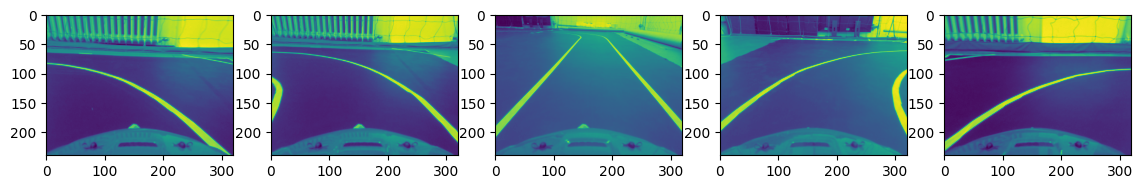

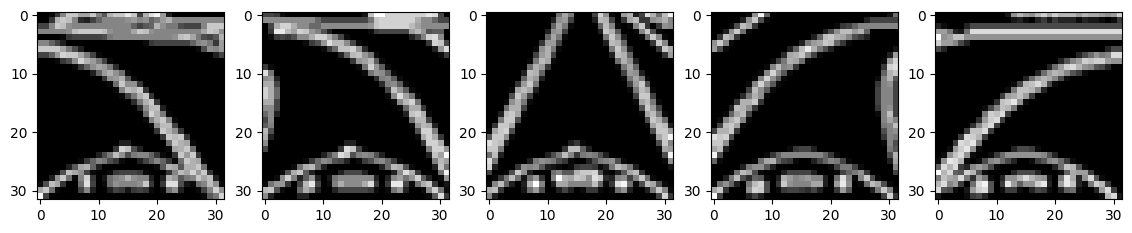

In [62]:
#create useful data
assert len(dss) > 0
ds = dss[0]
hes = np.rad2deg(ds['hes'][0.6])
# hes = ds['hes'][0.6]
print(hes)
imgs = ds['imgs']
locs = ds['locs']
print(f'dataset name: {ds["name"]}')

strong_left = None
strong_right = None
weak_left = None
weak_right = None
straight = None

i = 0
while (strong_left is None or strong_right is None or weak_left is None or weak_right is None or straight is None) and i < len(hes):
    if hes[i] < -20 and strong_right is None:
        strong_right = i
    if -6 < hes[i] < -5 and weak_right is None:
        weak_right = i
    if -0.001 < hes[i] < 0.001 and straight is None:
        straight = i
    if 5 < hes[i] < 6 and weak_left is None:
        weak_left = i
    if hes[i] > 20 and strong_left is None:
        strong_left = i    
    i += 1

print(f'strong left: {strong_left}')
print(f'weak left: {weak_left}')
print(f'straight: {straight}')
print(f'weak right: {weak_right}')
print(f'strong right: {strong_right}')


print(f'strong left: {strong_left}, he = {hes[strong_left]:.2f}') 
print(f'weak left: {weak_left}, he = {hes[weak_left]:.2f}')
print(f'straight: {straight}, he = {hes[straight]:.2f}')
print(f'weak right: {weak_right}, he = {hes[weak_right]:.2f}')
print(f'strong right: {strong_right}, he = {hes[strong_right]:.2f}')

img_strong_left = imgs[strong_left]
img_weak_left = imgs[weak_left]
img_straight = imgs[straight]
img_weak_right = imgs[weak_right]
img_strong_right = imgs[strong_right]

fig, ax = plt.subplots(1,5, figsize=(14,4))
ax[0].imshow(img_strong_left)
ax[1].imshow(img_weak_left)
ax[2].imshow(img_straight)
ax[3].imshow(img_weak_right)
ax[4].imshow(img_strong_right)
plt.show()

#preprocess images
img_strong_left = preprocess_image(img_strong_left, keep_bottom=0.8)
img_weak_left = preprocess_image(img_weak_left, keep_bottom=0.8)
img_straight = preprocess_image(img_straight, keep_bottom=0.8)
img_weak_right = preprocess_image(img_weak_right, keep_bottom=0.8)
img_strong_right = preprocess_image(img_strong_right, keep_bottom=0.8)

fig, ax = plt.subplots(1,5, figsize=(14,4))
ax[0].imshow(img_strong_left, cmap='gray')
ax[1].imshow(img_weak_left, cmap='gray')
ax[2].imshow(img_straight, cmap='gray')
ax[3].imshow(img_weak_right, cmap='gray')
ax[4].imshow(img_strong_right, cmap='gray')
plt.show()




In [85]:
# NETWORK ANALYSIS 

net_name = 'tmp_bk/models/tr_ds_sn12_he60_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L11_L210000_wd90_dr30.pt'
net_name = 'tmp_bk/models/base_a_32.pt'

net = HEstimator()
net.load_state_dict(torch.load(net_name))

input = img_strong_left.copy()

assert input.shape == (32, 32)
input = input.reshape(1, 1, 32, 32).astype(np.float32)

input = torch.from_numpy(input)

output = net(input)[0].item()

output = np.rad2deg(output)
print(output)

#load network


18.772658820564157


(4, 1, 5, 5)
(4, 4, 5, 5)
(32, 4, 5, 5)


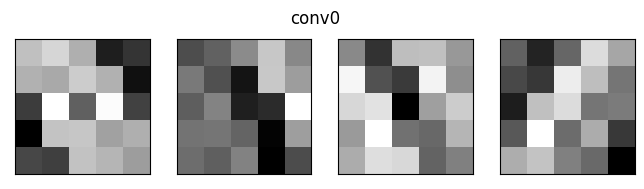

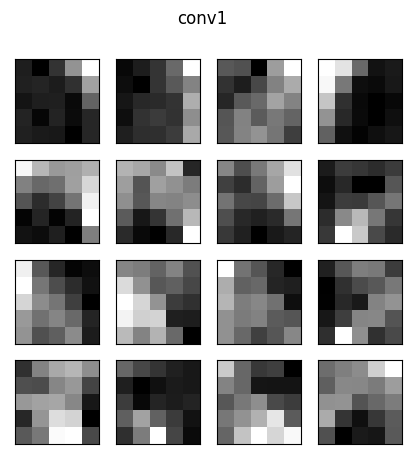

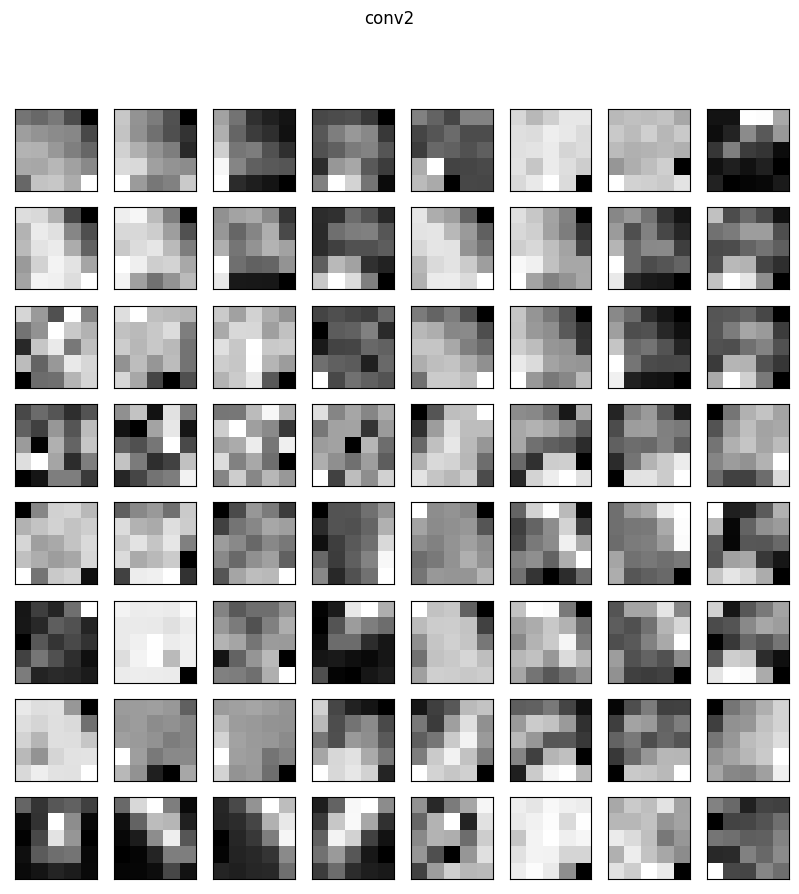

In [86]:
# VISUALIZE CONVOLUTIONAL FILTERS
conv_layers = []
children = list(net.children())
for i in range(len(children)):
    if isinstance(children[i], nn.Conv2d):
        conv_layers.append(children[i])
    elif isinstance(children[i], nn.Sequential):
        for child in children[i].children():
            if isinstance(child, nn.Conv2d):
                conv_layers.append(child)

c0 = conv_layers[0].weight.data.cpu().numpy()
c1 = conv_layers[1].weight.data.cpu().numpy()
c2 = conv_layers[2].weight.data.cpu().numpy()

def plot_nchw_data(data, h_num, v_num, title, size=(10, 10)):
    fig, axs = plt.subplots(h_num, v_num, figsize=size)
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    #plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()
    return fig

# fig0 = plot_nchw_data(c0, 4, 4, 'conv0')
print(c0.shape)
print(c1.shape)
print(c2.shape)

fig0 = plot_nchw_data(c0, 1, 4, 'conv0', size=(8,2))

fig1 = plot_nchw_data(c1, 4, 4, 'conv1', size=(5,5)) 

fig2 = plot_nchw_data(c2, 8, 8, 'conv2', size=(10,10))
